---
title: Validating reference gene expression prediction
author: Sabrina Mi
date: 9/6/2023
---

We are trying to replicate the Enformer result's in [Personal transcriptome variation is poorly explained by current genomic deep learning models, Huang et al](https://www.biorxiv.org/content/10.1101/2023.06.30.547100v1). They reported a 0.57 correlation in reference prediction across all genes. They used median GEUVADIS LCL gene expression data for their comparison and quantified predicted gene expression using the average of 10 bin window around each gene's TSS on the CAGE:B lymphoblastoid cell line track. I performed a similar analysis of Enformer performance along the reference genome, but instead I used a 3 bin window around the TSS and the CAGE:Brain, adult track to compare to observed GTEx brain cortex gene expression. I found 0.54 between predicted and observed reference gene expression. 

### Libraries and Definitions

In [26]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

enfref_dir = "/grand/TFXcan/imlab/users/lvairus/reftile_project/enformer-reference-epigenome"

def query_epigenome(chr_num, center_bp, n_bins=3, tracks=-1):
    """
    Parameters:
        path_to_enfref (str): path to the directory containing the concatenated reference enformer files
        chr_num (int/string): chromosome number
        center_bp (int): center base pair position (1-indexed)
        n_bins (int): number of bins to extract centered around center_bp (default: 896) 
            note: if the number of bins is even, the center bin will be in the second half of the array
        tracks (int list): list of tracks to extract (default: all 5313 tracks)

    Returns:
        epigen (np.array): enformer predictions centered at center_bp of shape (n_bins, len(tracks))
    """

    # from position choose center bin
    center_bin = center_bp // 128
    
    half_bins = n_bins // 2
    start_bin = center_bin - half_bins
    end_bin = center_bin + half_bins
    if n_bins % 2 != 0: # if n_bins is odd
        end_bin += 1

    with h5py.File(f"{enfref_dir}/chr{chr_num}_cat.h5", "r") as f:
        # get tracks if list provided
        if tracks == -1:
            epigen = f[f'chr{chr_num}'][start_bin:end_bin, :] 
        else:
            epigen = f[f'chr{chr_num}'][start_bin:end_bin, tracks] 

    return epigen

### Query Enformer predicted gene expression

In [ ]:
## Function to put CAGE predictions in list (in the same order as gene list by chromosome)
for chr in chr_list:
    gene_list = gene_dict[chr]
    for gene in gene_list:
        bins = query_epigenome(chr, hg38_annot.loc[gene]['transcription_start_site'], num_bins=10, tracks=[5110])
        CAGE_predictions[chr].append(np.average(bins))

### Calculate GEUVADIS reference gene expression

In [80]:
geuvadis_gex = pd.read_csv("/lus/grand/projects/TFXcan/imlab/data/1000G/expression/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz", sep="\t")
geuvadis_gex.head()

,TargetID,Gene_Symbol,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
0,ENSG00000152931.6,ENSG00000152931.6,5,59783540,0.101858,0.078110,0.048981,0.118597,0.004035,0.010925,...,0.088601,0.240010,0.137175,0.148494,0.038643,0.088509,0.029204,0.024423,0.044816,0.139186
1,ENSG00000183696.9,ENSG00000183696.9,7,48128225,8.183805,5.686911,2.434653,3.830894,6.612288,4.709646,...,13.428205,6.094500,12.536000,2.217262,3.573394,7.583364,4.052882,1.570378,4.900372,6.737308
2,ENSG00000139269.2,ENSG00000139269.2,12,57846106,1.199910,1.573572,0.521616,1.447225,3.565791,1.982681,...,3.225880,1.996067,2.854923,2.267343,1.331201,2.187895,1.004250,3.003316,1.984362,1.684954
3,ENSG00000169129.8,ENSG00000169129.8,10,116164515,0.831940,0.069778,0.931086,0.620941,1.660668,0.570481,...,1.023381,1.127852,0.774409,1.495854,0.895342,1.513521,0.826377,1.021201,0.952502,0.740565
4,ENSG00000134602.11,ENSG00000134602.11,X,131157293,27.646422,24.395572,16.445374,24.806650,25.113349,19.233988,...,25.079490,28.725528,24.450520,27.264069,26.912814,29.509210,26.462331,25.624009,25.707741,22.824957


In [81]:
geuvadis_gex['TargetID'] = geuvadis_gex['TargetID'].apply(lambda gene: gene.split('.')[0])
geuvadis_gex.set_index('TargetID', inplace=True)
# Calculate average gene expression
geuvadis_mean_gex = geuvadis_gex.drop(columns=['Gene_Symbol', 'Chr', 'Coord']).mean(axis=1)
geuvadis_mean_gex.name = 'geuvadis, mean'
# Calculate median gene expression
geuvadis_median_gex = geuvadis_gex.drop(columns=['Gene_Symbol', 'Chr', 'Coord']).median(axis=1)
geuvadis_median_gex.name = 'geuvadis, median'

## Split genes by chromosome

In [47]:
## Subset annotation to GEUVADIS genes
hg38_annot = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.protein_coding_TSS.txt", header=0, sep="\t")
hg38_annot = hg38_annot[hg38_annot["ensembl_gene_id"].isin(geuvadis_gex.index)]
gene_dict = hg38_annot.groupby('chromosome_name')['ensembl_gene_id'].apply(list).to_dict()
## Initialize CAGE predictions
hg38_annot.set_index("ensembl_gene_id", inplace=True)
chr_list = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "X"]
CAGE_predictions = {key: [] for key in chr_list}

## Query Enformer predicted gene expression

In [56]:
for chr in chr_list:
    gene_list = gene_dict[chr]
    for gene in gene_list:
        bins = query_epigenome(chr, hg38_annot.loc[gene]['transcription_start_site'], tracks=[5110])
        CAGE_predictions[chr].append(np.average(bins))
    break

### Plot correlation across genes

In [64]:
merged_dict = {chr: pd.DataFrame(index=gene_dict[chr]) for chr in chr_list}
for chr in chr_list:
    merged_dict[chr]['enformer, 3 bin'] = CAGE_predictions[chr]

In [65]:
for chr in chr_list:
    merged_dict[chr] = merged_dict[chr].merge(geuvadis_mean_gex, left_index=True, right_index=True, how='inner').dropna()
    merged_dict[chr] = merged_dict[chr].merge(geuvadis_median_gex, left_index=True, right_index=True, how='inner').dropna()

In [66]:
all_genes = pd.concat(merged_dict.values())
# #all_genes.to_csv("/home/s1mi/enformer_rat_data/output/hg38_predicted_vs_observed_expression_GEUVADIS.csv")

In [72]:
#all_genes = pd.read_csv("/home/s1mi/enformer_rat_data/output/hg38_predicted_vs_observed_expression_GEUVADIS.csv", index_col=0)
print("Pearson Correlation across all GEUVADIS genes, 3 bin", all_genes.corr(method = "pearson").iloc[0,1])
corr = scipy.stats.spearmanr(all_genes["geuvadis"], all_genes["enformer, 3 bin"])[0]
print("Spearman Correlation across all GEUVADIS genes, 3 bin:", corr)

Pearson Correlation across all GEUVADIS genes, 3 bin 0.20215477325106418
Spearman Correlation across all GEUVADIS genes, 3 bin: 0.7688261493752583


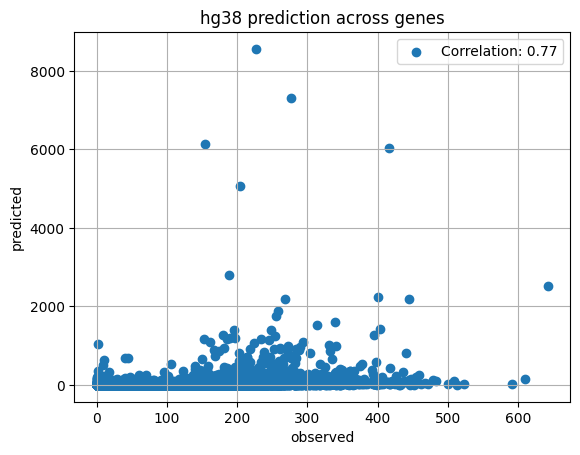

In [74]:
plt.scatter(all_genes['enformer, 3 bin'], all_genes['geuvadis'], label=f'Correlation: {corr:.2f}')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title("hg38 prediction across genes")
plt.legend()
plt.grid(True)
plt.show()

### Compare to 10 bin window predictions

In [75]:
import time
for chr in chr_list:
    tic = time.perf_counter()
    gene_list = merged_dict[chr].index
    predictions = []
    for gene in gene_list:
        bins = query_epigenome(chr, hg38_annot.loc[gene]['transcription_start_site'], n_bins=10, tracks=[5110])
        predictions.append(np.average(bins))
    merged_dict[chr]["enformer, 10 bin"] = predictions
    toc = time.perf_counter()
    print("Querying chromosome", chr, "genes...,", toc - tic, "seconds")

Querying chromosome 1 genes..., 69.03840435994789 seconds
Querying chromosome 2 genes..., 54.10317796189338 seconds
Querying chromosome 3 genes..., 37.46441020199563 seconds
Querying chromosome 4 genes..., 36.941509263939224 seconds
Querying chromosome 5 genes..., 31.623387236963026 seconds
Querying chromosome 6 genes..., 35.4050335889915 seconds
Querying chromosome 7 genes..., 32.40155419590883 seconds
Querying chromosome 8 genes..., 28.47602708893828 seconds
Querying chromosome 9 genes..., 23.366629968048073 seconds
Querying chromosome 10 genes..., 26.692642249981873 seconds
Querying chromosome 11 genes..., 36.21240806707647 seconds
Querying chromosome 12 genes..., 30.501199858961627 seconds
Querying chromosome 13 genes..., 13.312637477065437 seconds
Querying chromosome 14 genes..., 20.186696789925918 seconds
Querying chromosome 15 genes..., 20.195753266918473 seconds
Querying chromosome 16 genes..., 18.143485559965484 seconds
Querying chromosome 17 genes..., 31.225896001094952 secon

In [94]:
all_genes = pd.concat(merged_dict.values())
all_genes = all_genes[["geuvadis, mean", "geuvadis, median", "enformer, 3 bin", "enformer, 10 bin"]]
all_genes.to_csv("/home/s1mi/enformer_rat_data/output/hg38_predicted_vs_observed_expression_GEUVADIS.csv")

In [90]:
print("Pearson Correlation")
all_genes.corr(method = "pearson")

Pearson Correlation


,"geuvadis, mean","geuvadis, median","enformer, 3 bin","enformer, 10 bin"
"geuvadis, mean",1.000000,0.999931,0.202155,0.193256
"geuvadis, median",0.999931,1.000000,0.201489,0.192641
"enformer, 3 bin",0.202155,0.201489,1.000000,0.923923
"enformer, 10 bin",0.193256,0.192641,0.923923,1.000000


In [89]:
print("Spearman Correlation:")
all_genes.corr(method = "spearman")

Spearman Correlation:


,"geuvadis, mean","geuvadis, median","enformer, 3 bin","enformer, 10 bin"
"geuvadis, mean",1.000000,0.999273,0.768826,0.759941
"geuvadis, median",0.999273,1.000000,0.770554,0.761739
"enformer, 3 bin",0.768826,0.770554,1.000000,0.963611
"enformer, 10 bin",0.759941,0.761739,0.963611,1.000000



The highest correlation between observed and predicted expression in the 14,585 GEUVADIS genes is 0.77, by using a 3 bin average around the TSS for predicted reference and median gene expression across GEUVADIS individuals as observed reference. This is actually better than the reported 0.57 correlation by Huang et al, but I will run the original code to triple check.

### Original Code

I cloned [personalized-expression-benchmark](https://github.com/ni-lab/personalized-expression-benchmark.git).

The first difference I noticed in their analysis is that they subset to 3259 genes in the GEUVADIS EUR dataset found to have at least one significant cis-eQTL.

### Original Code

My only modification was hard-coding paths and removing the fasta folder argument in [`personalized-expression-benchmark/enformer/run_enformer_reference.py`](https://github.com/ni-lab/personalized-expression-benchmark/blob/main/enformer/run_enformer_reference.py)

```
module load conda
conda activate ml-python
cd /home/s1mi/Github/personalized-expression-benchmark

python3 enformer/run_enformer_reference.py . data/gene_list.csv

```

In [99]:
output = pd.read_csv("/home/s1mi/Github/personalized-expression-benchmark/output/reference_predictions.csv")
merged_output = output.merge(geuvadis_median_gex, left_on="geneId", right_index=True).drop(columns=["mean", "max"])

In [102]:
print("Pearson Correlation:")
merged_output.corr(method="pearson")

Pearson Correlation:


,tss3,tss10,"geuvadis, median"
tss3,1.000000,0.835206,0.197672
tss10,0.835206,1.000000,0.218041
"geuvadis, median",0.197672,0.218041,1.000000


In [103]:
print("Spearman Correlation:")
merged_output.corr(method="spearman")

Spearman Correlation:


,tss3,tss10,"geuvadis, median"
tss3,1.000000,0.893283,0.501058
tss10,0.893283,1.000000,0.569476
"geuvadis, median",0.501058,0.569476,1.000000


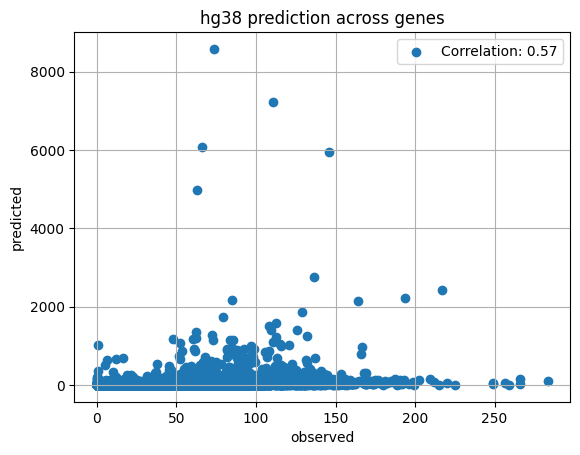

In [106]:
corr = merged_output.corr(method="spearman").iloc[1,2]
plt.scatter(all_genes['enformer, 10 bin'], all_genes['geuvadis, median'], label=f'Correlation: {corr:.2f}')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title("hg38 prediction across genes")
plt.legend()
plt.grid(True)
plt.show()